In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# import imageio
import cv2
import os
from pathlib import Path

In [36]:
from IPython.core.display import HTML

HTML('''
<style>
    .jp-OutputArea-output pre {
        background-color: white;
    }
    .jp-OutputArea-output img {
        background-color: white;
    }
</style>
''')


In [0]:
train_df = pd.read_csv(os.path.join(os.getcwd() ,"data", "train.csv"))
test_df = pd.read_csv(os.path.join(os.getcwd() ,"data", "test.csv"))

# Data Exploration
We start with a simple data exploration to understand the data we are working with. We will look at the number of videos in the training and testing sets, the distribution of the labels, the number of frames in each video, and the resolution of the videos.

In [26]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag,n_frames,resolution
543,v_TennisSwing_g17_c05.avi,TennisSwing,201,"(320, 240)"
387,v_ShavingBeard_g12_c04.avi,ShavingBeard,185,"(320, 240)"
131,v_PlayingCello_g10_c01.avi,PlayingCello,145,"(320, 240)"
445,v_ShavingBeard_g21_c03.avi,ShavingBeard,90,"(320, 240)"
72,v_CricketShot_g18_c04.avi,CricketShot,67,"(320, 240)"
355,v_Punch_g25_c04.avi,Punch,300,"(320, 240)"
418,v_ShavingBeard_g17_c04.avi,ShavingBeard,297,"(320, 240)"
264,v_Punch_g11_c07.avi,Punch,300,"(320, 240)"
511,v_TennisSwing_g13_c01.avi,TennisSwing,69,"(320, 240)"
55,v_CricketShot_g15_c07.avi,CricketShot,96,"(320, 240)"


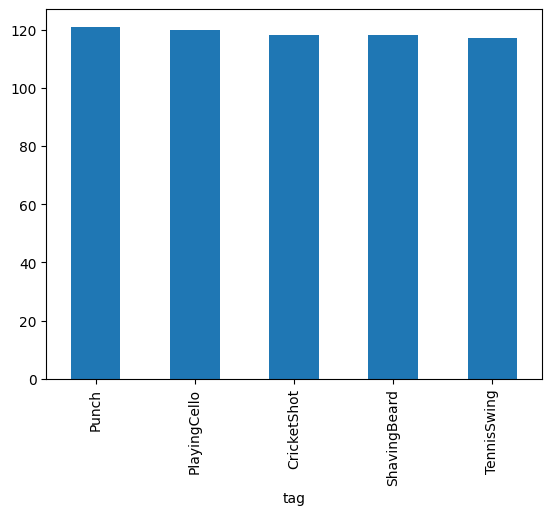

In [27]:
train_df['tag'].value_counts().plot(kind='bar')
plt.show()

The distribution of the labels is balanced, with each label has around 120 videos.

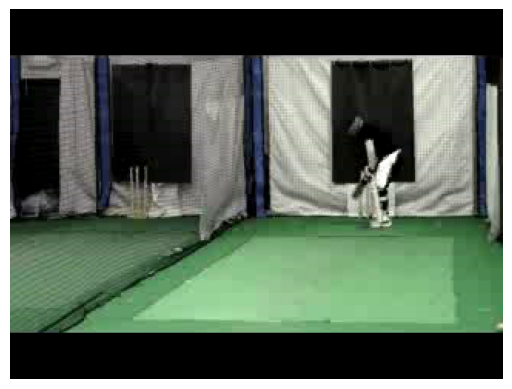

In [25]:
# display a frame from a random video
video_path = os.path.join(os.getcwd() ,"data", "train", train_df['video_name'].values[0])
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

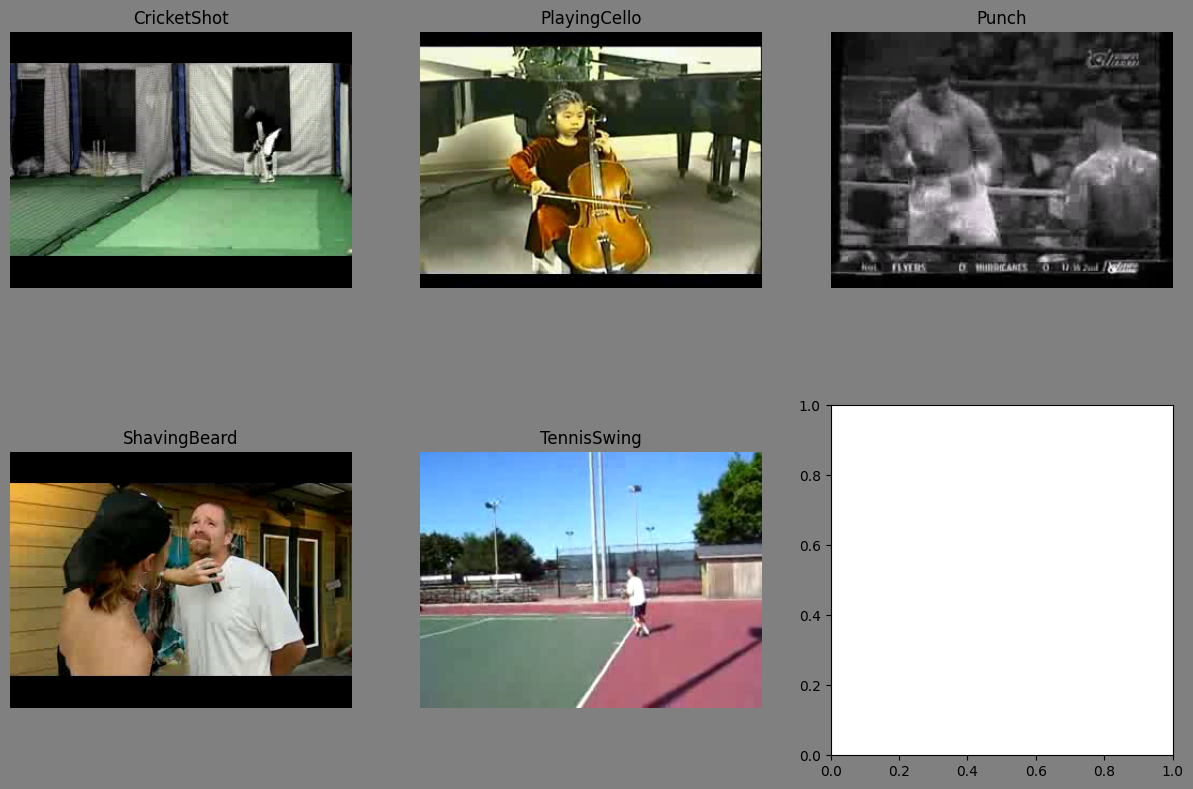

In [44]:
# display a frame from each category, to understand the difference between them
# we will display 6 frames, one from each category
# 
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.patch.set_facecolor('gray')  # Set the figure background to white
for i, tag in enumerate(train_df['tag'].unique()):
    video_path = os.path.join(os.getcwd() ,"data", "train", train_df[train_df['tag'] == tag]['video_name'].values[0])
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    axs[i//3, i%3].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(tag)
    axs[i//3, i%3].set_facecolor('gray')
plt.show()

In the example abouve, we can see different scenes from the videos in the dataset. For example, under the "Punch" and "ShavingBeard" categories, we can see more than one person in the frame, while in the "TennisSwing" cartegory, the field of view is wider and the person is alone. After observing possible issues in cross categories, let's dive into a single category and see if there are any issues within the category.

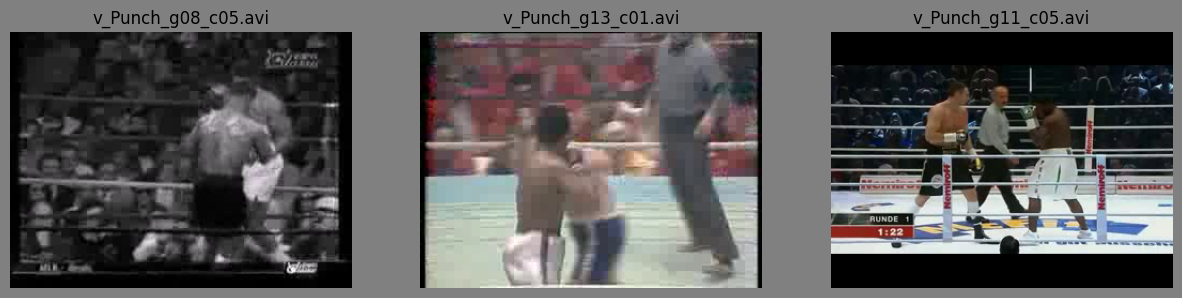

In [68]:
# display 3 frames from the "Punch" category from 3 different videos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('gray')  # Set the figure background to white
random_idx = np.random.randint(0, len(train_df[train_df['tag'] == 'Punch']), 3)
for i, video_name in enumerate(train_df[train_df['tag'] == 'Punch']['video_name'].values[random_idx]):
    video_path = os.path.join(os.getcwd() ,"data", "train", video_name)
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    axs[i].set_title(video_name)
    axs[i].set_facecolor('gray')
plt.show()

In the example above, we can see that the "Punch" category has a variety of scenes, some with 2 persons, and some with 3, there are also frame that are black and white. There is also different of the angle of the camera, some are from the side and some are from the front. This variety in the category can make it harder for the model to learn the features of the category.

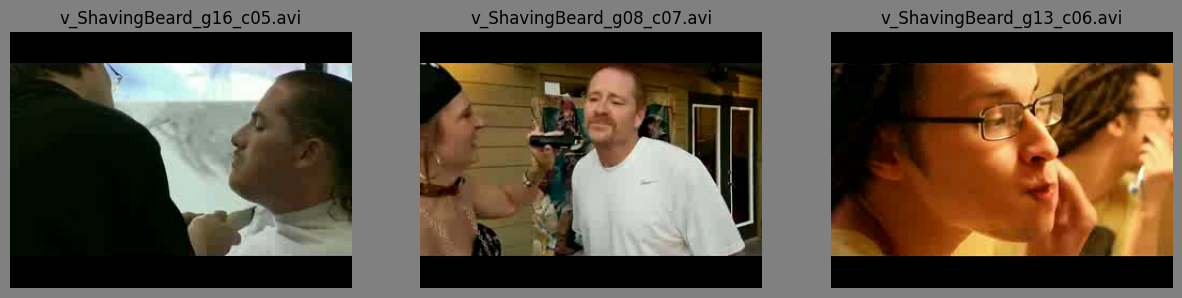

In [55]:
# display 3 frames from the "ShavingBeard" category from 3 different videos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_facecolor('gray')  # Set the figure background to white
random_idx = np.random.randint(0, len(train_df[train_df['tag'] == 'ShavingBeard']), 3)
for i, video_name in enumerate(train_df[train_df['tag'] == 'ShavingBeard']['video_name'].values[random_idx]):
    video_path = os.path.join(os.getcwd() ,"data", "train", video_name)
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    axs[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    axs[i].set_title(video_name)
    axs[i].set_facecolor('gray')
plt.show()

The example above, are firstly vary bizarad, a video of a guy getting shaved by some women?! anyway, the category has a variety of scenes, some are with one person and it's mirrior reflection, other with other people shaving them. It's also suffering from different point of view, and different lighting conditions.

In addition, each scene was capture several times in the dataset, the name of the scene is tagged as "g#" and the name of the different captures are tagged as "c#". This can be a problem for the model, as it can learn the features of the scene and not the category itself.

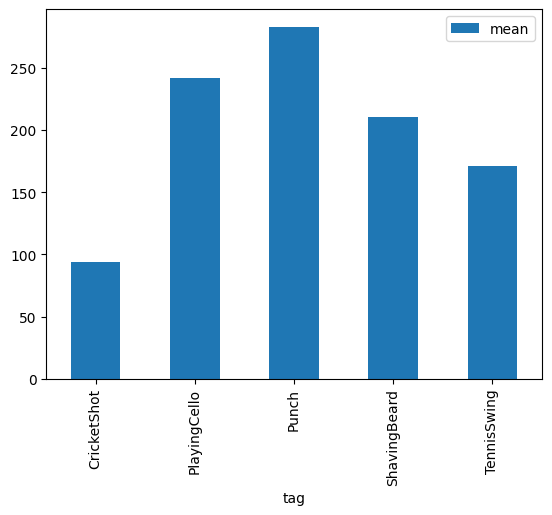

,mean,max,min
tag,,,
CricketShot,93.754237,262,46
PlayingCello,241.600000,388,105
Punch,283.132231,300,68
ShavingBeard,210.737288,336,90
TennisSwing,171.213675,368,69


In [18]:
# for each video in the directory, extract the number of frames it's composed of, and add it to the dataframe
def count_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return total_frames

train_df['n_frames'] = train_df['video_name'].map(lambda x: count_frames(os.path.join(os.getcwd() ,"data", "train", x)))
test_df['n_frames'] = test_df['video_name'].map(lambda x: count_frames(os.path.join(os.getcwd() ,"data", "test", x)))

train_df.groupby('tag')['n_frames'].agg(['mean']).plot(kind='bar')
plt.show()

train_df.groupby('tag')['n_frames'].agg(['mean', 'max', 'min'])


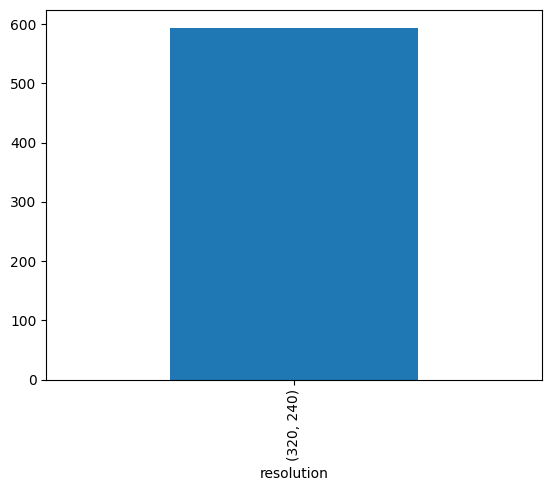

In [19]:
def get_resolution(video_path):
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    return width, height

train_df['resolution'] = train_df['video_name'].map(lambda x: get_resolution(os.path.join(os.getcwd() ,"data", "train", x)))
train_df['resolution'] = train_df['resolution'].map(lambda x: str(x))

train_df['resolution'].value_counts().plot(kind='bar')
plt.show()
